# Saving and Loading Models

TensorFlow에서 모형을 저장하고 불러오는 방법을 알아본다.

## Import Resources

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import time
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf


In [3]:
tf.__version__

'2.4.1'

In [4]:
import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

In [5]:
print('Using:')
print('TensorFlow version:', tf.__version__)
print('tf.keras version:', tf.keras.__version__)
print('Running on GPU' if tf.test.is_gpu_available() else 'GPU device not found. Running on CPU')

Using:
TensorFlow version: 2.4.1
tf.keras version: 2.4.0
Running on GPU


## Load the Dataset

In [6]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

4423680/4422102 [==============================] - 0s 0us/step


In [9]:
# Preprocess the data (these are NumPy arrays)
x_train = x_train.reshape(60000, 784).astype("float32") / 255
x_test = x_test.reshape(10000, 784).astype("float32") / 255

y_train = y_train.astype("float32")
y_test = y_test.astype("float32")

In [10]:
# Reserve 10,000 samples for validation
x_val = x_train[-10000:]
y_val = y_train[-10000:]
x_train = x_train[:-10000]
y_train = y_train[:-10000]

## Explore the Dataset

In [11]:
num_training_examples = len(x_train)
num_validation_examples = len(x_val)
num_test_examples = len(x_test)

print('There are {:,} images in the training set'.format(num_training_examples))
print('There are {:,} images in the validation set'.format(num_validation_examples))
print('There are {:,} images in the test set'.format(num_test_examples))

There are 50,000 images in the training set
There are 10,000 images in the validation set
There are 10,000 images in the test set


In [12]:
x_train = x_train.reshape(num_training_examples, 28, 28,1)
x_val = x_val.reshape(num_validation_examples, 28, 28,1)
x_test = x_test.reshape(num_test_examples, 28, 28,1)

training_set = tf.data.Dataset.from_tensor_slices((x_train, y_train))
validation_set = tf.data.Dataset.from_tensor_slices((x_val, y_val))
test_set = tf.data.Dataset.from_tensor_slices((x_test, y_test))

In [13]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 
               'Sandal',      'Shirt',   'Sneaker',  'Bag',   'Ankle boot']

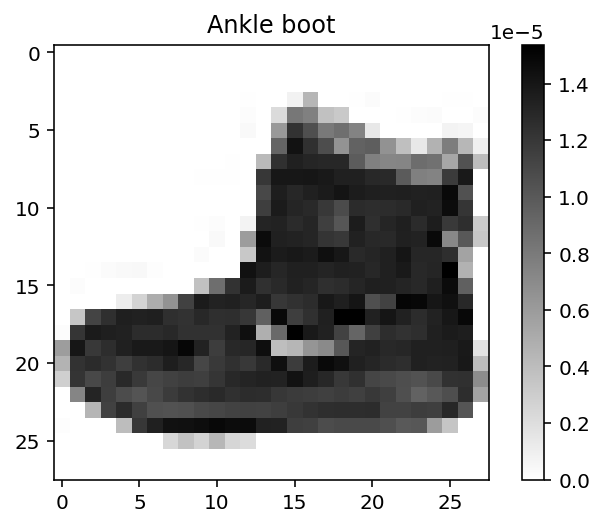

In [14]:
for image, label in training_set.take(1):
    image = image.numpy().squeeze()
    label = label.numpy()

plt.imshow(image, cmap=plt.cm.binary)
plt.title(class_names[int(label)])
plt.colorbar()
plt.show()

## Create Pipeline

In [15]:
def normalize(image, label):
    image = tf.cast(image, tf.float32)
    image /= 255
    return image, label

batch_size = 64

training_batches = training_set.cache().shuffle(num_training_examples//4).batch(batch_size).map(normalize).prefetch(1)
validation_batches = validation_set.cache().batch(batch_size).map(normalize).prefetch(1)
testing_batches = test_set.cache().batch(batch_size).map(normalize).prefetch(1)

## Build and Train the Model



In [16]:
layer_neurons = [512, 256, 128]

dropout_rate = 0.5

model = tf.keras.Sequential()

model.add(tf.keras.layers.Flatten(input_shape=(28,28,1)))

for neurons in layer_neurons:
    model.add(tf.keras.layers.Dense(neurons, activation = 'relu'))
    model.add(tf.keras.layers.Dropout(dropout_rate))

model.add(tf.keras.layers.Dense(10, activation = 'softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 512)               401920    
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0

In [17]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

EPOCHS = 4

history = model.fit(training_batches,
                    epochs=EPOCHS,
                    validation_data=validation_batches)

Epoch 1/4
782/782 [==============================] - 6s 4ms/step - loss: 2.3032 - accuracy: 0.0960 - val_loss: 2.3029 - val_accuracy: 0.0968
Epoch 2/4
782/782 [==============================] - 2s 3ms/step - loss: 2.3028 - accuracy: 0.1017 - val_loss: 2.3028 - val_accuracy: 0.0968
Epoch 3/4
782/782 [==============================] - 2s 3ms/step - loss: 2.3030 - accuracy: 0.1022 - val_loss: 2.3026 - val_accuracy: 0.1008
Epoch 4/4
782/782 [==============================] - 2s 3ms/step - loss: 2.3028 - accuracy: 0.0995 - val_loss: 2.3028 - val_accuracy: 0.0968


## Saving and Loading Models

TensorFlow 에서는 모형을 2가지 형태로 저장할 수 있다. 하나는 TensorFlow의 SavedModel format 이고 다른 하나는 HDF5 files format으로 Keras models type 이다.

### Saving and Loading Models in HDF5 Format

 `.save(filepath)` method를 사용하여 모형을 저장한다. 예를 들면 다음과 같다.

```python
my_model.save('./test_model.h5')
```

파일의 확장자는 반드시 `.h5` 으로 한다. 

 HDF5 file 은 다음과 같은 내용을 저장한다.:

* model의 구조.
* model의 weight values
* model의 훈련과 관련된 설정 `compile` method의 parameter값.
* optimizer에 대한 정보


기본적으로 `.save()` method는 에러 없이 기존의 파일을 덮어쓰기 한다.`overwrite=False` 을 설정하면 파일 덮어쓰기 전에 prompt한다.

In [18]:
t = time.time()

saved_keras_model_filepath = './{}.h5'.format(int(t))

model.save(saved_keras_model_filepath)

일단 저장된 모형은 `tf.keras.models.load_model(filepath)` 을 통해 불러들인다. 

In [19]:
reloaded_keras_model = tf.keras.models.load_model(saved_keras_model_filepath)

reloaded_keras_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 512)               401920    
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0

`reloaded_keras_model`은 원래 `model` 과 같은 복사본이 된다. 다음과 같은 명령어로 Prediction 을 수행할 수 있다.

In [20]:
for image_batch, label_batch in testing_batches.take(1):
    prediction_1 = model.predict(image_batch)
    prediction_2 = reloaded_keras_model.predict(image_batch)
    difference = np.abs(prediction_1 - prediction_2)
    print(difference.max())

0.0


결과가 0.0 인것은 같은 이미지에 대해 같은 prediction을 수행한 결과이다.

### Saving and Loading TensorFlow SavedModels

`model.save('my_model')`을 호출하면 다음을 포함하는 my_model 폴더를 생성한다.

```
$ ls my_model
assets  saved_model.pb  variables
```

모델 아키텍처 및 훈련 구성(옵티마이저, 손실 및 메트릭 포함)은 saved_model.pb에 저장된다. 가중치는 variables/ 디렉토리에 저장된다.


In [25]:
model.save("my_model")

In [27]:
reconstructed_model = tf.keras.models.load_model("my_model")

TensorFlow 의 **SavedModel** format로 모형을 저장하기 위해서 `tf.saved_model.save(model, export_dir)` function을 사용한다. 예를 들면 다음과 같다.

```python
tf.saved_model.save(my_model, './saved_models')
```

주의할 것은 파일의 이름을 쓰는 것이 아니라 모형이 저장될 directory명을 쓴다는 것이다. 
왜냐면 SavedModels 은 단일한 file로 저장되는 것이 아니기 때문이다. `tf.saved_model.save()` function은 `assets` folder, `variables` folder 그리고 `saved_model.pb` 을 생성한다.

SavedModel files 은 다음과 같은 내용을 포함한다:

* model weights.
* TensorFlow graph - prediction, training, evaluation에 사용된다.
* model의 구조와 관련된 설정 정보


In [21]:
t = time.time()

savedModel_directory = './{}'.format(int(t))

tf.saved_model.save(model, savedModel_directory)

SavedModel로 저장된 모형은 `tf.saved_model.load(export_dir)` 로 불러들일 수 있다. 

In [22]:
reloaded_SavedModel = tf.saved_model.load(savedModel_directory)

`tf.saved_model.load` 은 Keras object가 아니다. 따라서 `.fit`, `.predict`, `.summary` 등과 같은 methods를 사용할 수 없다. `reloaded_SavedModel` 로 Prediction을 수행하려면 Keras model로 re-load해야 한다.

predictions을 수행하기 위해서 다음과 같이 사용한다.

```python
reloaded_SavedModel(image_batch, training=False)
```


In [23]:
for image_batch, label_batch in testing_batches.take(1):
    prediction_1 = model.predict(image_batch)
    prediction_2 = reloaded_SavedModel(image_batch, training=False).numpy()
    difference = np.abs(prediction_1 - prediction_2)
    print(difference.max())

0.0


TensorFlow SavedModel로 부터 Keras model을 가져오기 위해서 `tf.keras.models.load_model` function을 사용한다. 

In [24]:
reloaded_keras_model_from_SavedModel = tf.keras.models.load_model(savedModel_directory)

reloaded_keras_model_from_SavedModel.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 512)               401920    
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0

## Saving Models During Training


훈련중에 validation loss는 훈련이 잘 진행되는지 확인할 수 있는 지표 역할을 한다. overfitting이 일어나지 않는 최적 validation loss의 모형을 저장할 수 있다. 

`tf.keras` 에서 다음과 같은 callback을 사용한다:

```python
tf.keras.callbacks.ModelCheckpoint('./best_model.h5', monitor='val_loss', save_best_only=True)
```

위의 callback은 매 epoch마다 Keras HDF5 file로 저장한다. `save_best_only=True` argument을 주면, 가장 최적의 모형만을 저장한다.

In [ ]:
model = tf.keras.Sequential([
        tf.keras.layers.Flatten(input_shape=(28,28,1)),
        tf.keras.layers.Dense(256, activation = 'relu'),
        tf.keras.layers.Dense(128, activation = 'relu'),
        tf.keras.layers.Dense(64, activation = 'relu'),
        tf.keras.layers.Dense(10, activation = 'softmax')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Stop training when there is no improvement in the validation loss for 10 consecutive epochs
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

# Save the Model with the lowest validation loss
save_best = tf.keras.callbacks.ModelCheckpoint('./best_model.h5',
                                               monitor='val_loss',
                                               save_best_only=True)

history = model.fit(training_batches,
                    epochs = 100,
                    validation_data=validation_batches,
                    callbacks=[early_stopping, save_best])

Epoch 1/100
782/782 [==============================] - 1s 2ms/step - loss: 0.9524 - accuracy: 0.6444 - val_loss: 0.6791 - val_accuracy: 0.7531
Epoch 2/100
782/782 [==============================] - 1s 1ms/step - loss: 0.5907 - accuracy: 0.7834 - val_loss: 0.5482 - val_accuracy: 0.7968
Epoch 3/100
782/782 [==============================] - 1s 1ms/step - loss: 0.5212 - accuracy: 0.8117 - val_loss: 0.5032 - val_accuracy: 0.8177
Epoch 4/100
782/782 [==============================] - 1s 1ms/step - loss: 0.4769 - accuracy: 0.8296 - val_loss: 0.4689 - val_accuracy: 0.8332
Epoch 5/100
782/782 [==============================] - 1s 1ms/step - loss: 0.4423 - accuracy: 0.8422 - val_loss: 0.4446 - val_accuracy: 0.8367
Epoch 6/100
782/782 [==============================] - 1s 1ms/step - loss: 0.4179 - accuracy: 0.8486 - val_loss: 0.4232 - val_accuracy: 0.8496
Epoch 7/100
782/782 [==============================] - 1s 1ms/step - loss: 0.4012 - accuracy: 0.8546 - val_loss: 0.4122 - val_accuracy: 0.8526